In [1]:
import os
import sys

import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt

from typing import Tuple, List
from collections import defaultdict
from stable_baselines3.dqn.dqn import DQN

import torch
import torch.nn as nn

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")

from sumo_rl import SumoEnvironment
from sumo_rl.agents import QLAgent
from sumo_rl.exploration import EpsilonGreedy

from custom_ql import CustomQLAgent
from custom_dqn import CustomDQN

# Utility functions

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w) / w, mode="same")

def load_metric(dir, runs, episode, metric, window):
    data = []
    for run in range(1, runs + 1):
        files = os.listdir(dir)
        file = next(f for f in files if f"run{run}" in f and f"ep{episode}" in f and f.endswith(".csv"))
        df = pd.read_csv(os.path.join(dir, file))
        values = df[metric].values
        values = moving_average(values, window)
        data.append(values)
    data = np.array(data)
    return data.mean(axis=0), data.std(axis=0)

def compare_algorithms(runs, episodes, data_dir, metric="system_total_waiting_time", window=50):
    baseline_dir = data_dir + "/baseline"
    custom_dir   = data_dir + "/custom"

    baseline_first_mean, baseline_first_std = load_metric(baseline_dir, runs, 1, metric, window)
    baseline_last_mean, baseline_last_std = load_metric(baseline_dir, runs, episodes, metric, window)

    custom_first_mean, custom_first_std = load_metric(custom_dir, runs, 1, metric, window)
    custom_last_mean, custom_last_std = load_metric(custom_dir, runs, episodes, metric, window)

    t = np.arange(len(baseline_first_mean)) * 5

    fig, axes = plt.subplots(4, 1, figsize=(12, 20))
    fig.tight_layout(pad=4)

    ax = axes[0]
    ax.plot(t, baseline_first_mean, label="Baseline — First Episode", linewidth=2)
    ax.fill_between(t, baseline_first_mean - baseline_first_std,
                       baseline_first_mean + baseline_first_std, alpha=0.25)

    ax.plot(t, baseline_last_mean, label="Baseline — Last Episode", linewidth=2)
    ax.fill_between(t, baseline_last_mean - baseline_last_std,
                       baseline_last_mean + baseline_last_std, alpha=0.25)

    ax.set_title(f"{metric} — Baseline: First vs Last Episodes")
    ax.set_xlabel("Seconds")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend()

    ax = axes[1]
    ax.plot(t, custom_first_mean, label="Custom — First Episode", linewidth=2)
    ax.fill_between(t, custom_first_mean - custom_first_std,
                       custom_first_mean + custom_first_std, alpha=0.25)

    ax.plot(t, custom_last_mean, label="Custom — Last Episode", linewidth=2)
    ax.fill_between(t, custom_last_mean - custom_last_std,
                       custom_last_mean + custom_last_std, alpha=0.25)

    ax.set_title(f"{metric} — Custom: First vs Last Episodes")
    ax.set_xlabel("Seconds")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend()

    ax = axes[2]
    ax.plot(t, baseline_first_mean, label="Baseline — First Episode", linewidth=2)
    ax.fill_between(t, baseline_first_mean - baseline_first_std,
                       baseline_first_mean + baseline_first_std, alpha=0.25)

    ax.plot(t, custom_first_mean, label="Custom — First Episode", linewidth=2)
    ax.fill_between(t, custom_first_mean - custom_first_std,
                       custom_first_mean + custom_first_std, alpha=0.25)

    ax.set_title(f"{metric} — Baseline vs Custom (First Episode)")
    ax.set_xlabel("Seconds")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend()

    ax = axes[3]
    ax.plot(t, baseline_last_mean, label="Baseline — Last Episode", linewidth=2)
    ax.fill_between(t, baseline_last_mean - baseline_last_std,
                       baseline_last_mean + baseline_last_std, alpha=0.25)

    ax.plot(t, custom_last_mean, label="Custom — Last Episode", linewidth=2)
    ax.fill_between(t, custom_last_mean - custom_last_std,
                       custom_last_mean + custom_last_std, alpha=0.25)

    ax.set_title(f"{metric} — Baseline vs Custom (Last Episode)")
    ax.set_xlabel("Seconds")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend()

    plt.show()


# Q-learning

In [3]:
runs = 5
episodes = 5
num_seconds = 3600
delta_time = 5

### Baseline Q-learning Agent

In [ ]:
env = SumoEnvironment(
    net_file="nets/4x4-Lucas/4x4.net.xml",
    route_file="nets/4x4-Lucas/4x4c1c2c1c2.rou.xml",
    use_gui=False,
    num_seconds=num_seconds,
    min_green=5,
    delta_time=delta_time
)

for run in range(1, runs + 1):
    initial_states = env.reset()
    ql_agents = {
        ts: QLAgent(
            starting_state=env.encode(initial_states[ts], ts),
            state_space=env.observation_space,
            action_space=env.action_space,
            alpha=0.1,
            gamma=0.99,
            exploration_strategy=EpsilonGreedy(initial_epsilon=0.05, min_epsilon=0.005, decay=1),
        )
        for ts in env.ts_ids
    }

    for episode in range(1, episodes + 1):
        if episode != 1:
            initial_states = env.reset()
            for ts in initial_states.keys():
                ql_agents[ts].state = env.encode(initial_states[ts], ts)

        infos = []
        done = {"__all__": False}
        while not done["__all__"]:
            actions = {ts: ql_agents[ts].act() for ts in ql_agents.keys()}

            s, r, done, info = env.step(action=actions)

            for agent_id in s.keys():
                ql_agents[agent_id].learn(next_state=env.encode(s[agent_id], agent_id), reward=r[agent_id])

        env.save_csv(f"outputs/4x4/baseline/ql-4x4grid_run{run}", episode)

env.close()

### Custom Q-learning Agent

In [ ]:
env = SumoEnvironment(
    net_file="nets/4x4-Lucas/4x4.net.xml",
    route_file="nets/4x4-Lucas/4x4c1c2c1c2.rou.xml",
    use_gui=False,
    num_seconds=num_seconds,
    min_green=5,
    delta_time=delta_time,
)

for run in range(1, runs + 1):
    initial_states = env.reset()
    ql_agents = {
        ts: CustomQLAgent(
            starting_state=env.encode(initial_states[ts], ts),
            state_space=env.observation_space,
            action_space=env.action_space,
            alpha=0.1,
            gamma=0.99,
            initial_epsilon=0.05, 
            min_epsilon=0.005, 
            epsilon_decay=1,
        )
        for ts in env.ts_ids
    }

    for episode in range(1, episodes + 1):
        if episode != 1:
            initial_states = env.reset()
            for ts in initial_states.keys():
                ql_agents[ts].state = env.encode(initial_states[ts], ts)

        infos = []
        done = {"__all__": False}
        while not done["__all__"]:
            actions = {ts: ql_agents[ts].act() for ts in ql_agents.keys()}

            s, r, done, info = env.step(action=actions)

            for agent_id in s.keys():
                ql_agents[agent_id].learn(next_state=env.encode(s[agent_id], agent_id), reward=r[agent_id])

        env.save_csv(f"outputs/4x4/custom/ql-4x4grid_run{run}", episode)

env.close()

### Comparison of Q-learning Agents

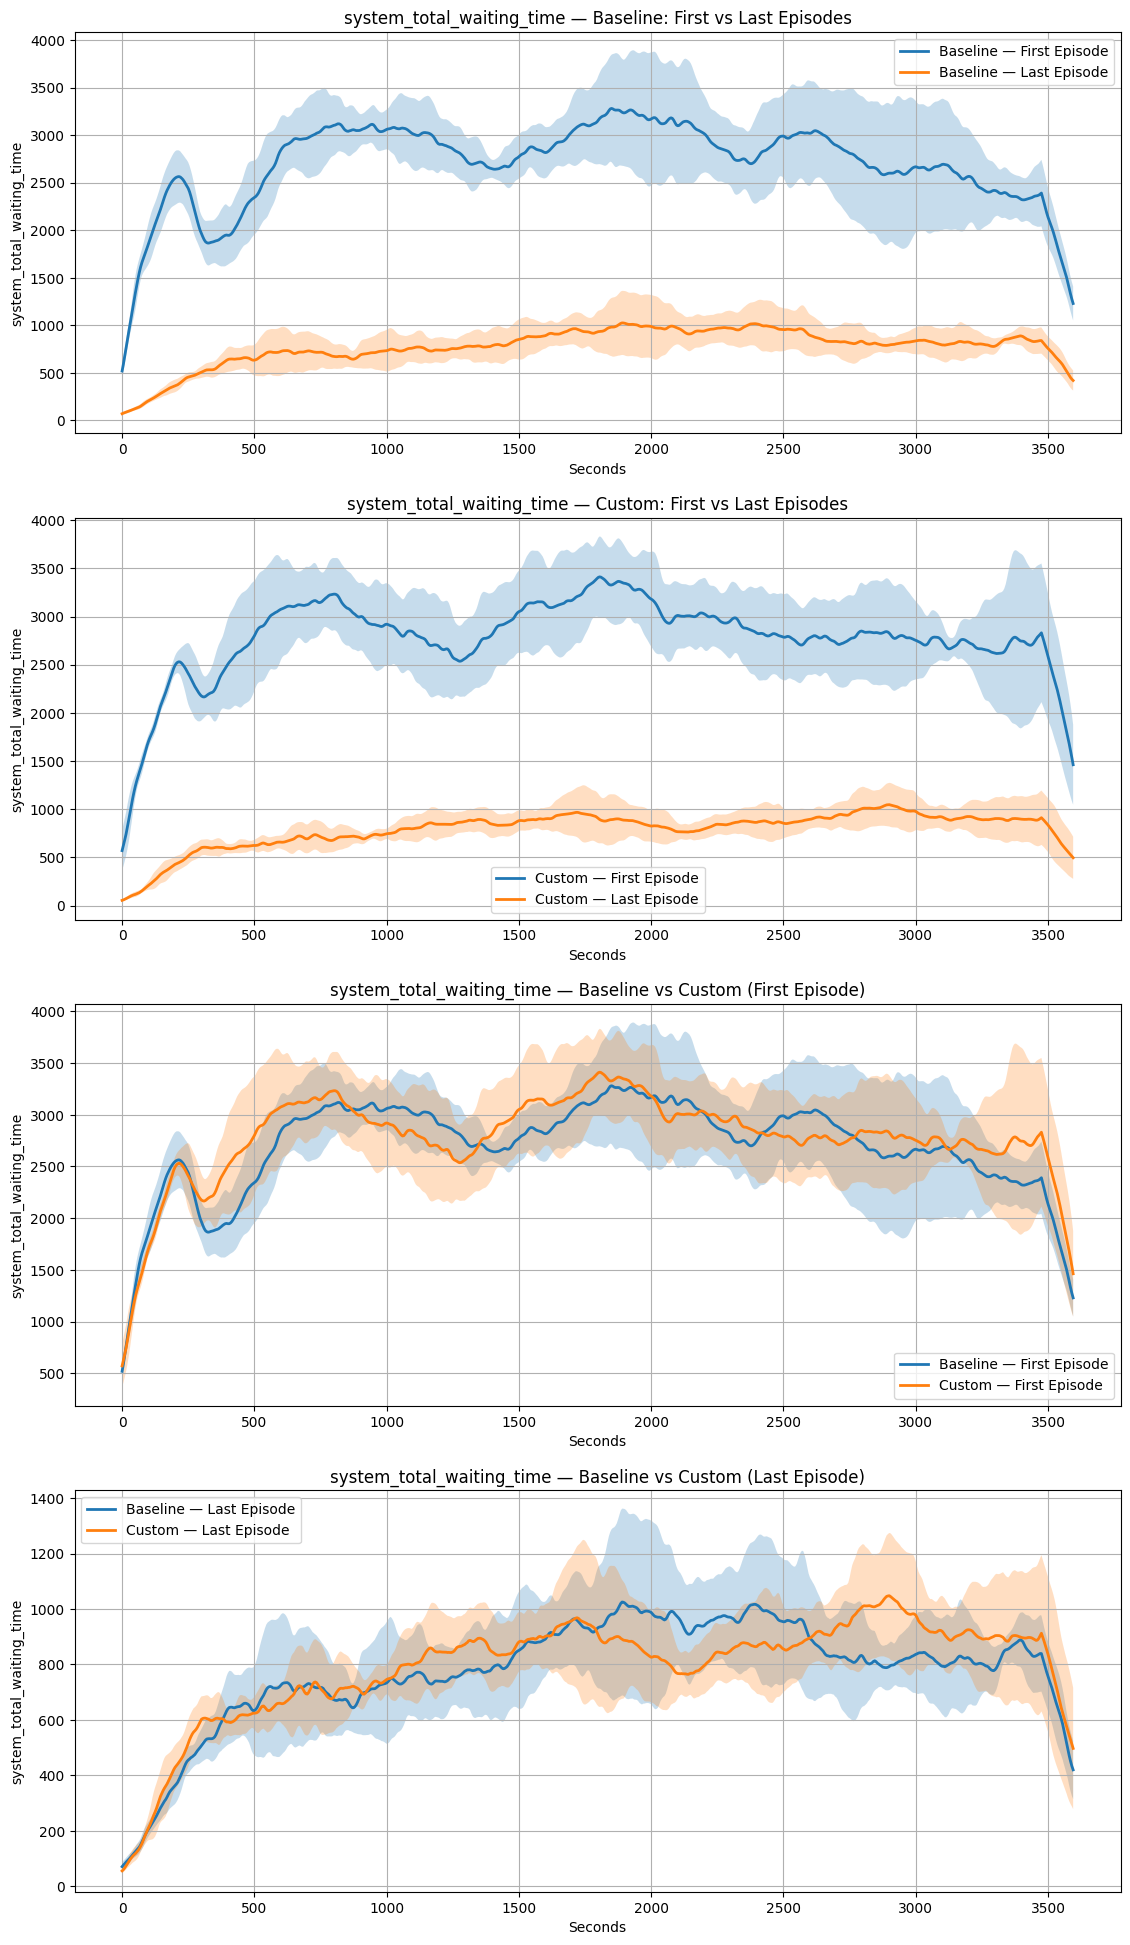

In [4]:
compare_algorithms(runs, episodes, "outputs/4x4")

**Results:**
* algorithms are identical (we didn't imporoved anything), so results similar
* waiting time for last episode is much smaller, so we can see that algotithm successfully trained

# DQN

In [5]:
runs = 5
episodes = 5
num_seconds = 1800
delta_time = 5

### Baseline DQN Agent

In [ ]:
for run in range(1, runs + 1):
    env = SumoEnvironment(
        net_file="nets/big-intersection/big-intersection.net.xml",
        single_agent=True,
        route_file="nets/big-intersection/routes.rou.xml",
        out_csv_name=f"outputs/big-intersection/baseline/dqn_big-intersection_run{run}",
        use_gui=False,
        num_seconds=num_seconds,
        yellow_time=4,
        min_green=5,
        max_green=60,
        delta_time=delta_time
    )
    
    model = DQN(
        env=env,
        policy="MlpPolicy",
        learning_rate=1e-3,
        learning_starts=0,
        buffer_size=5000,
        train_freq=4,
        target_update_interval=100,
        exploration_fraction=0.1,
        exploration_final_eps=0.01,
        verbose=1
    )
    model.learn(total_timesteps=num_seconds * episodes // delta_time)

### Custom DQN Agent

In [ ]:
for run in range(1, runs + 1):
    env = SumoEnvironment(
        net_file="nets/big-intersection/big-intersection.net.xml",
        single_agent=True,
        route_file="nets/big-intersection/routes.rou.xml",
        out_csv_name=f"outputs/big-intersection/custom/dqn_big-intersection_run{run}",
        use_gui=False,
        num_seconds=num_seconds,
        yellow_time=4,
        min_green=5,
        max_green=60,
    )
    
    model = CustomDQN(
        env=env,
        learning_rate=1e-3,
        learning_starts=0,
        buffer_size=5000,
        train_freq=4,
        target_update_interval=100,
        exploration_fraction=0.1,
        exploration_final_eps=0.01,
    )
    model.learn(total_timesteps=num_seconds * episodes // delta_time)

### Comparison of DQN Agents

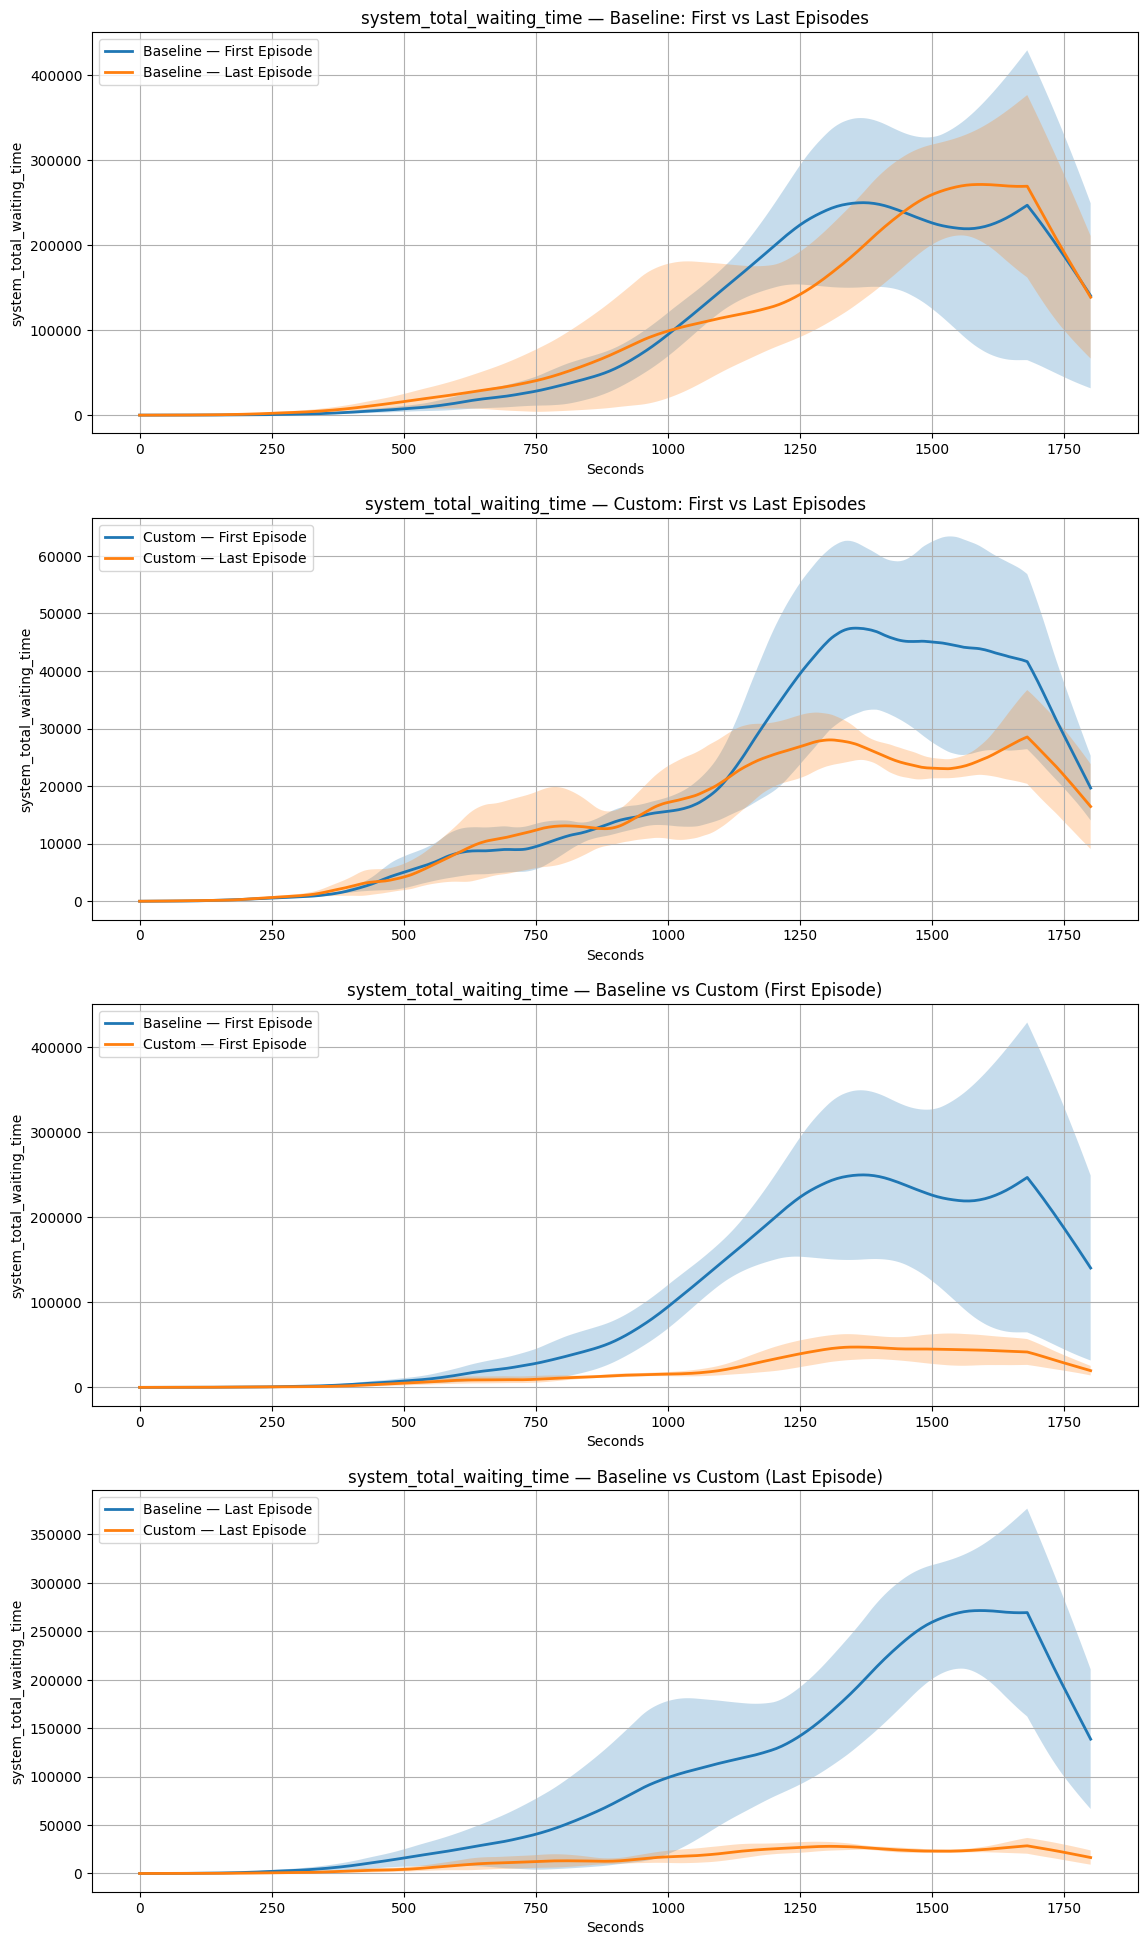

In [6]:
compare_algorithms(runs, episodes, "outputs/big-intersection")

**Results:**
* our modificated version of DQN (with Prioritized Experience Replay and Dueling Heads) is able outperform DQN from stable-baselines3 very signifacantly
* from difference between first and last episodes we can see that DQN without PER and Dueling Heads needs much more time to begin improve metrics